In [1]:
import numpy as np
import matplotlib as mpl
import sympy as sym
from scipy import optimize, special, integrate

In [2]:
%matplotlib inline
sym.init_printing()
mpl.pyplot.style.use(['seaborn-dark-palette','seaborn-poster'])

In this notebook, I derive the optimal threshold rule by adopting Figuerora-Lopez and Nisen (2013), and deriving the optimal scalar paremeter in the fixed

In [3]:
infill_dim = 10
n_stddev = 1
n_Delta =  1

In [4]:
x, z, b = sym.symbols('x z b', real=True)
a, n, Delta, sigma, gamma  = sym.symbols('a n Delta sigma gamma', real=True, positive=True)

In [5]:
abs_lap_dens = sym.sqrt(2) * ((gamma * sym.sqrt(Delta))**(-1) 
            * sym.exp(-sym.sqrt(2) * abs(x)  / (gamma * sym.sqrt(Delta))))
abs_gauss_dens = (sym.exp(-abs(x / (sigma * sym.sqrt(Delta)))**2 / 2) / (sigma * sym.sqrt(2 * sym.pi * Delta))) * 2 

In [6]:
non_abs_lap_dens = sym.sqrt(2) * ((gamma * sym.sqrt(Delta))**(-1) 
                                  * sym.exp(-sym.sqrt(2) * x  / (gamma * sym.sqrt(Delta))))

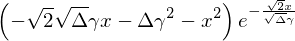

In [7]:
sym.integrate(x**2 * non_abs_lap_dens, x)

In [8]:
erfcx = sym.erfc(x) * sym.exp(x**2)

In [9]:
m1 = sym.sqrt(2 / sym.pi)

In [10]:
prop_lap_var = (Delta * gamma**2 - sym.exp(-sym.sqrt(2) * z / (sym.sqrt(Delta) * gamma))
                * (sym.sqrt(2) * sym.sqrt(Delta) * gamma * z + Delta * gamma**2 + z**2))

In [11]:
prop_gauss_var = (sym.exp(-z**2 / (2 * Delta * sigma**2)) 
                 * (m1 * sigma * z * sym.sqrt(Delta) + Delta * sigma**2 
                    * erfcx.replace(x, z / (sym.sqrt(2 * Delta) * sigma))))

In [12]:
simplified_gauss_var = prop_gauss_var.replace(z, a * sym.sqrt(Delta) + b * Delta).replace(
    Delta, sym.log(n) / n).replace(sigma,1).simplify()

In [13]:
simplified_lap_var = prop_lap_var.replace(z, a * sym.sqrt(Delta) + b * Delta).replace(
    Delta, sym.log(n) / n).replace(gamma,1).simplify()

In [211]:
2 * np.sqrt(np.log(2))

In [219]:
n_func = sym.lambdify(n, (simplified_gauss_var - simplified_lap_var).replace(b,0).factor().replace(
    a, 2 * sym.sqrt(sym.sqrt(2))).simplify())

In [224]:
?np.linspace

In [232]:
np.abs(list(map(n_func, np.linspace(1, 1e7, num=100)))).max()

In [96]:
diff_lambda = sym.lambdify((a,b), sym.expand_log((simplified_gauss_var - simplified_lap_var).collect(n)).replace(
    n, 1e6))

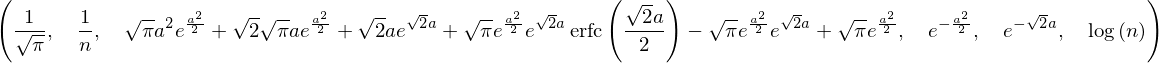

In [149]:
sym.expand_log((simplified_gauss_var - simplified_lap_var).collect(n)).replace(b,0).factor().args

In [142]:
term1, term2, term3 = sym.expand_log((simplified_gauss_var - simplified_lap_var).collect(n)).replace(b,0).factor().args[2:5]

In [144]:
a_func = sym.lambdify(a, term1 * term2 * term3)

In [145]:
a_func(1)

In [154]:
optimize.minimize(lambda x: a_func(x)**2, x0=(1))

      fun: 1.6482363210349792e-16
 hess_inv: array([[ 0.18739695]])
      jac: array([ -2.17982588e-09])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([ 1.67549234])

In [160]:
# alpha_func_delta = lambda x : float(sym.nsolve(expr.replace(sigma,1).replace(Delta,x), 1))
xvals1 = np.linspace(.0001,8,100)
yvals1 = list(map(lambda x: a_func(x)**2,xvals1))

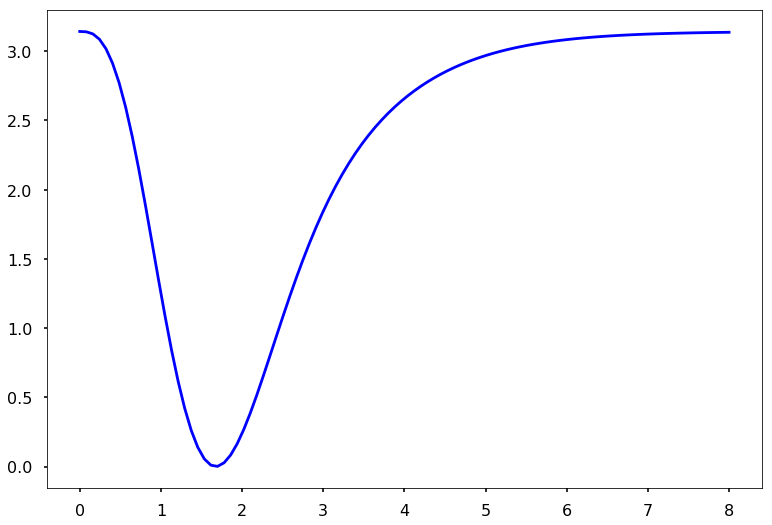

In [161]:
fig1, ax1 = mpl.pyplot.subplots()

ax1.plot(xvals1, yvals1, color='blue')
# ax1.set_ylim([-10, 50])

In [167]:
bterm1, _, bterm2, bterm3 = sym.expand_log((simplified_gauss_var - simplified_lap_var).collect(n)).replace(
    a,1.65).factor().args[3:7]

In [203]:
b_func = sym.lambdify(b , (bterm1 * bterm2 * bterm3 / n**3).simplify().collect(n).args[1].factor().replace(n,1000))

In [209]:
xvals1 = np.linspace(-10, 10,100)
yvals1 = list(map(lambda x: b_func(x)**2,xvals1))
fig1, ax1 = mpl.pyplot.subplots()

ax1.plot(xvals1, yvals1, color='blue')
# ax1.set_ylim([-10, 50])

In [183]:
sym.limit(b_eqn / n**3 * sym.log(n), n, sym.oo)

In [ ]:
fig, ax = mpl.pyplot.subplots()
xvals = np.linspace(.001,20,100)
yvals1 = list(map(special.erfcx,xvals))
yvals2 = [(4 / np.pi**.5) * (np.sqrt(x**2 + 4) + 3*x)**(-1) for x in xvals]
yvals3 = [(2 / np.pi**.5) * (np.sqrt(x**2 + 2) + x)**(-1) for x in xvals]
ax.plot(xvals, yvals1, color='blue')
ax.plot(xvals, yvals2, color='red')
ax.plot(xvals, yvals3, color='green')

In [406]:
iterated_log_trunc_rule = lambda n : np.sqrt(2) * np.sqrt(np.log(np.log(n)) / n)
figuerora_trunc_rule = lambda n : np.sqrt(3) * np.sqrt(np.log(n) / n)
todorov_li_tauchen = lambda n : 4 * n**(-.49)

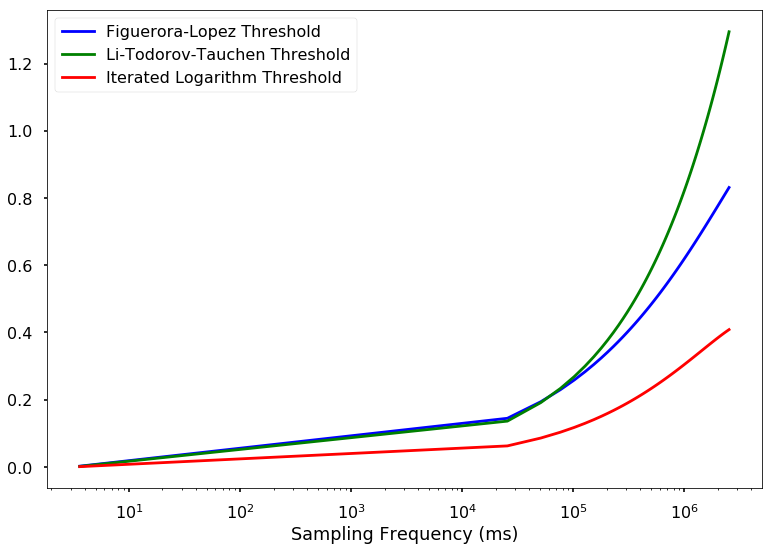

In [407]:
truncation_thresh_fig, truncation_thresh_ax = mpl.pyplot.subplots()
nvals = np.linspace(1e-7, 1e-1, 100)
nvals_as_seconds = pd.to_timedelta(7 * nvals, unit='h') / np.timedelta64(1, 'ms')
figuerora_series = pd.Series(list(map(figuerora_trunc_rule, nvals**(-1))), index = nvals_as_seconds ).sort_index()
li_todorov_series = pd.Series(list(map(todorov_li_tauchen, nvals**(-1))), index = nvals_as_seconds ).sort_index()
iterated_log_series = pd.Series(list(map(iterated_log_trunc_rule, nvals**(-1))),
                                index = nvals_as_seconds ).sort_index()
truncation_thresh_ax.plot(figuerora_series, label='Figuerora-Lopez Threshold', color='blue')
truncation_thresh_ax.plot(li_todorov_series, label='Li-Todorov-Tauchen Threshold', color='green')
truncation_thresh_ax.plot(iterated_log_series, label='Iterated Logarithm Threshold', color='red')
truncation_thresh_ax.set_xscale('log')
truncation_thresh_ax.legend()
truncation_thresh_ax.set_xlabel('Sampling Frequency (ms)')